# CAPSTONE PROJECT - CV - PNEUMONIA DETECTION
## Authors: CV1 - GROUP- 4

# DOMAIN: Health Care
**• CONTEXT:**
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

**• DATA DESCRIPTION:**
In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

Dataset has been attached along with this project. Please use the same for this capstone project.
Original link to the dataset : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data [ for your reference only ]. You can refer to the details of the dataset in the above link

Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.

**• PROJECT OBJECTIVE:** Design a DL based algorithm for detecting pneumonia.

**• PROJECT TASK:**

Milestone 2:
Input:
Preprocessed output from Milestone-1

Process:
‣ Step 1: Fine tune the trained basic CNN models for classification.

‣ Step 2: Apply Transfer Learning model for classification

## Step 3: Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest.

‣ Step 4: Pickle the model for future prediction

‣ Step 5: Final Report

Submission:
Final report, Jupyter Notebook with all the steps in Milestone-1 and Milestone-2

In [ ]:
pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:00


In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
import random
import csv
import itertools
import cv2
import math
import os
import PIL
import pickle
import torch
import torchvision
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["axes.grid"] = False

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc,classification_report, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import regularizers
from tensorflow.keras.layers import Convolution2D, Activation, SpatialDropout2D
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import backend
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization ,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet , VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

from keras.utils import to_categorical
from keras import regularizers
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.utils import np_utils

from glob import glob
from collections import Counter
from zipfile import ZipFile
from pathlib import Path
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle

from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from PIL import Image
from numpy import asarray

##Step 1: Import the data.
##Step 2: Map training and testing images to its classes.
##Step 3: Map training and testing images to its annotations.

In [ ]:
from google.colab import drive  #Google drive mount
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classInfo = pd.read_csv('/content/drive/My Drive/Colab Notebooks/My Python Projects/CAPSTONE PROJECT/CV capstone/stage_2_detailed_class_info.csv')
trainlabels = pd.read_csv("/content/drive/My Drive/Colab Notebooks/My Python Projects/CAPSTONE PROJECT/CV capstone/stage_2_train_labels.csv")
trainImagesPath = "/content/drive/My Drive/Colab Notebooks/My Python Projects/CAPSTONE PROJECT/CV capstone/stage_2_train_images.zip"
testImagesPath = "/content/drive/My Drive/Colab Notebooks/My Python Projects/CAPSTONE PROJECT/CV capstone/stage_2_test_images.zip"
sampleSubPath = Path("/content/drive/My Drive/Colab Notebooks/My Python Projects/CAPSTONE PROJECT/CV capstone/stage_2_sample_submission.csv")

In [ ]:
# Unzip the train images file
with ZipFile(trainImagesPath,'r') as zipfile:
  zipfile.extractall("/content/drive/My Drive/Colab Notebooks/My Python Projects/CAPSTONE PROJECT/Train images/")

In [ ]:
# Unzip the test images file
with ZipFile(testImagesPath,'r') as zip1:
  zip1.extractall("/content/drive/My Drive/Colab Notebooks/My Python Projects/CAPSTONE PROJECT/Test images/")

# Faster-RCNN

In [ ]:
seed = 42
num_classes = 2
batch_size = 10
train_img_size = 256
origin_img_size = 1024
scale_factor = train_img_size / origin_img_size
np.random.seed(seed)

TRAIN_DIR = "Train images/stage_2_train_images/"
TEST_DIR = "Test images/stage_2_test_images/"
ROOT_DIR = "/content/drive/My Drive/Colab Notebooks/My Python Projects/CAPSTONE PROJECT/"
LABELS_FILE = "CV capstone/stage_2_train_labels.csv"
SUBMISSION_FILE = "CV capstone/stage_2_sample_submission.csv"
rcnn_losses = ["loss_objectness", "loss_box_reg", "loss_rpn_box_reg"]

In [ ]:
train_imgs = os.listdir(os.path.join(ROOT_DIR, TRAIN_DIR))
test_imgs =  [patienId + ".dcm" for patienId in pd.read_csv(os.path.join(ROOT_DIR, SUBMISSION_FILE)).patientId]

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, valid_imgs = train_test_split(train_imgs, test_size=0.25, random_state=seed)

print(f"Number of training samples: {len(train_imgs)}")
print(f"Number of validation samples: {len(valid_imgs)}")

Number of training samples: 20013
Number of validation samples: 6671


In [ ]:
train_label_df = pd.read_csv(os.path.join(ROOT_DIR, LABELS_FILE))
train_label_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


#### Our model require box coordinates in format X0, X1. We also multiply bounding box coordinates with scale_factor since we will train our model on images of size 256 instead of their original size 1024. R-CNN also require area of bounding box as input.

In [ ]:
isna_count = len(train_label_df[train_label_df.Target == 0]) # number of images without bounding box
train_label_df = train_label_df[train_label_df.Target == 1]
train_label_df.rename(columns={"x": "X0", "y": "Y0"}, inplace=True)
train_label_df["X1"] = train_label_df["X0"] + train_label_df["width"]
train_label_df["Y1"] = train_label_df["Y0"] + train_label_df["height"]
train_label_df[["X0", "X1", "Y0", "Y1"]] = train_label_df[["X0", "X1", "Y0", "Y1"]] * scale_factor
train_label_df["area"] = train_label_df["width"] * scale_factor * train_label_df["height"] * scale_factor
train_label_df.drop(["width", "height"], axis=1, inplace=True)
train_label_df.head()

,patientId,X0,Y0,Target,X1,Y1,area
4,00436515-870c-4b36-a041-de91049b9ab4,66.00,38.00,1,119.25,132.75,5045.4375
5,00436515-870c-4b36-a041-de91049b9ab4,140.50,38.00,1,204.50,151.25,7248.0000
8,00704310-78a8-4b38-8475-49f4573b2dbb,80.75,144.25,1,120.75,170.25,1040.0000
9,00704310-78a8-4b38-8475-49f4573b2dbb,173.75,143.75,1,214.25,178.00,1387.1250
14,00aecb01-a116-45a2-956c-08d2fa55433f,72.00,80.50,1,95.50,114.25,793.1250


#### Now let´s check how many images have zero, one or more bounding boxes

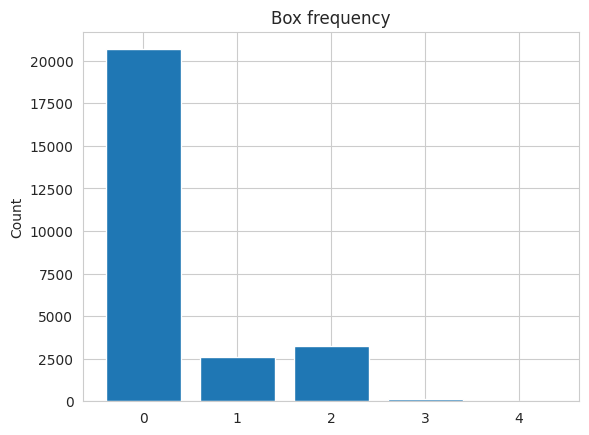

In [ ]:
from collections import Counter

cnt = Counter(train_label_df.patientId)
sample_batch = [sample[0] + ".dcm" for sample in cnt.most_common(2)] # We will take two imgs with 4 boxes to display
counts = pd.Series(cnt.values()).value_counts()
counts[0] = isna_count
plt.title("Box frequency")
plt.ylabel("Count")
plt.xticks(counts.index)
plt.bar(counts.index, counts)
plt.show()
del cnt

In [ ]:
counts.sort_values(ascending=False)

0    20672
2     3266
1     2614
3      119
4       13
dtype: int64

#### We see that most of images do not have any bounding box. There is also a handful of images with three and four bounding boxes. Previously we calculated bounding boxes area so we can now display area distribution.

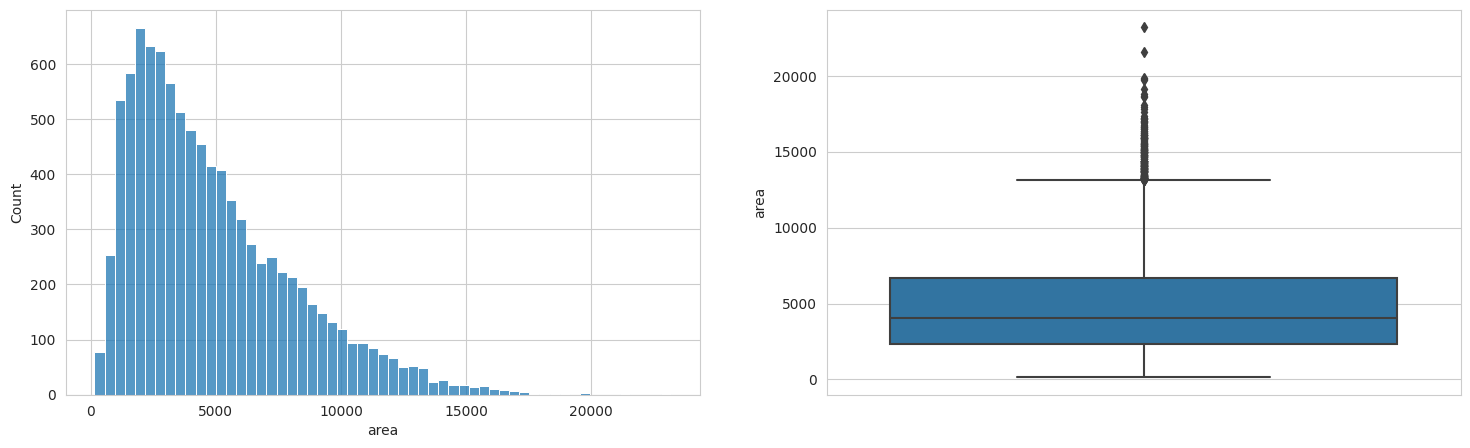

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(data=train_label_df, x="area", ax=axs[0])
sns.boxplot(y=train_label_df["area"])
plt.show()

#### We see that most of boxes have area smaller than 7000. There are also outliers with area greater than 15000. Now we will define some helper functions to display samples batch along with boxes.

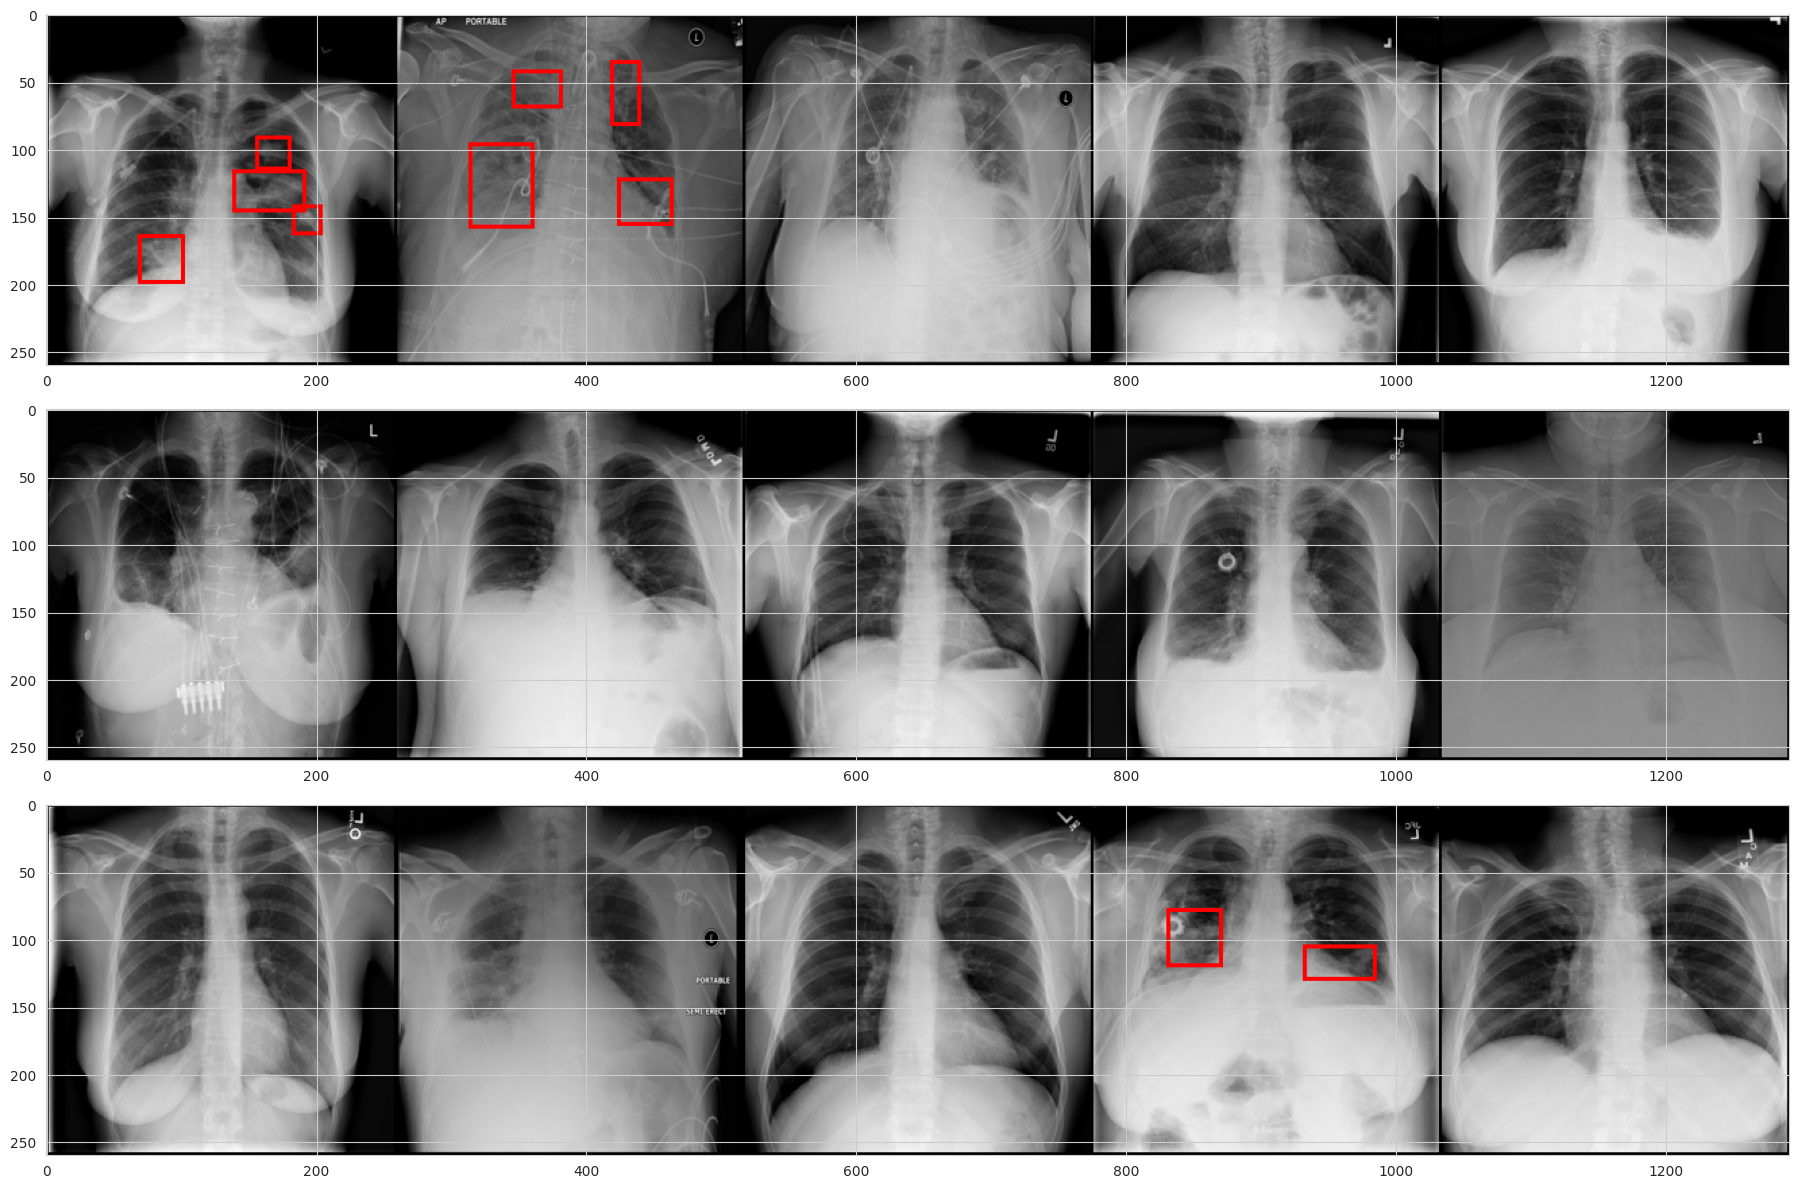

In [ ]:
from torchvision.utils import draw_bounding_boxes, make_grid


def find_boxes(img_name, label_df):
    patient_id = img_name.split(".")[0]
    boxes = label_df[label_df.patientId == patient_id]
    boxes_coord = boxes[["X0", "Y0", "X1", "Y1"]].to_numpy()

    return boxes_coord, boxes.area.to_numpy()


def read_images(img_names, label_df, resize):
    batch = []
    for img_name in img_names:
        img_path = os.path.join(ROOT_DIR, TRAIN_DIR, img_name)
        img = PIL.Image.fromarray(pydicom.dcmread(img_path).pixel_array).convert("RGB")
        img = img.resize(resize)
        img = np.array(img)

        boxes, _ = find_boxes(img_name, label_df)

        img = torch.tensor(img, dtype=torch.uint8)
        boxes = torch.tensor(boxes, dtype=torch.int32)
        batch.append((img, boxes))
    return batch


def plot_samples(batch, n_rows=3, n_cols=5, box_color="red", titles=None, box_width=3, fig_size=(20,12)):
    assert len(batch) >= n_rows * n_cols, f"Not enough samples to display, required at least {n_rows * n_cols} samples"
    fig, axs = plt.subplots(n_rows, 1, figsize=fig_size)
    fig.tight_layout()
    imgs_with_boxes = []
    for sample in batch[:n_rows * n_cols]:
        scores = None
        if len(sample) == 2:
            image, boxes = sample
        else:
            image, boxes, scores = sample
            scores = [f"Score: {score:.2f}" for score in scores]

        img = draw_bounding_boxes(image=image.permute(2, 0, 1),
                                  boxes=boxes,
                                  colors=box_color,
                                  labels=scores,
                                  width=box_width)
        imgs_with_boxes.append(img)

    for i, ax in enumerate(axs):
        if titles:
            ax.set_title(titles[i], fontsize=18)
        img_with_boxes = make_grid(imgs_with_boxes[i * n_cols: (i + 1) * n_cols]).numpy()
        ax.imshow(np.transpose(img_with_boxes, (1, 2, 0)))
    plt.show()

sample_batch = np.concatenate([sample_batch, np.random.choice(train_imgs, size=13)])
sample_batch = read_images(sample_batch, train_label_df, (train_img_size, train_img_size))
plot_samples(sample_batch)

#### Some bounding boxes covers small part of the lung while others covers most of the lung.

### Image augmentation
#### Now we will use a nifty library for image augmentation imgaug. The library can perform geometric transformations along with bounding boxes, masks and key points. In addition we add some noice and blur to image.



In [ ]:
# Define a class 'Augmentation' for applying image augmentations
class Augmentation:
    def __init__(self,
                 x_translation=(-0.05, 0.05),
                 rotate=(-5, 5),
                 scale=(0.9, 1.1),
                 noice=(0, 10),
                 blur=(0, 0.1)):

        # Define the augmentation transformations using imgaug.Sequential
        self.transform = iaa.Sequential([
            iaa.Affine(translate_percent={"x": x_translation}, scale=scale, rotate=rotate),
            iaa.AdditiveGaussianNoise(scale=noice),
            iaa.GaussianBlur(sigma=blur)])

    # Implement the __call__ method, which will be called when the class object is called as a function
    def __call__(self, image, boxes):
        # Convert the bounding boxes coordinates into imgaug format BoundingBoxesOnImage
        bbs = BoundingBoxesOnImage([BoundingBox(x1=box[0], y1=box[1], x2=box[2], y2=box[3])
                                    for box in boxes], shape=image.shape)

        # Apply the defined augmentations to the image and bounding boxes
        image, bbs = self.transform(image=image, bounding_boxes=bbs)

        # Convert the bounding boxes back to the original format (x1, y1, x2, y2) array
        return image, bbs.to_xyxy_array()

    # Worker initialization function for multi-processing (not used in this code snippet)
    def worker_init_fn(self, worker_id):
        """Set a unique seed for each worker to ensure different augmentations."""
        imgaug.seed(np.random.get_state()[1][0] + worker_id)

In [ ]:
from torchvision.transforms import PILToTensor, ConvertImageDtype

class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, img_names, train_img_size, labels=None):
        self.root = root
        self.transforms = transforms
        self.img_names = img_names
        self.resize = (train_img_size, train_img_size)
        self.labels = labels

    def __getitem__(self, idx):
        """Load image, boxes and process them"""
        img_name = self.img_names[idx]

        img_path = os.path.join(self.root, self.img_names[idx])
        img = PIL.Image.fromarray(pydicom.dcmread(img_path).pixel_array).convert("RGB")
        img = img.resize(self.resize)
        img = np.array(img)

        if self.labels is None:
            return torch.tensor(img / 255.).permute(2, 0, 1).float()

        boxes, area = find_boxes(img_name, self.labels)
        n_objects = len(boxes)
        if self.transforms is not None:
            img, boxes = self.transforms(img, boxes)

        img = torch.tensor(img / 255.).permute(2, 0, 1).float()

        target = {}
        target["image_id"] = torch.tensor([idx])
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.ones(n_objects, dtype=torch.int64)
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.zeros(n_objects, dtype=torch.int32)
        return img, target

    def __len__(self):
        return len(self.img_names)

    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [ ]:
from torch.utils.data import DataLoader

augmentation = Augmentation()
train_ds = PneumoniaDataset(os.path.join(ROOT_DIR, TRAIN_DIR), augmentation, train_imgs, train_img_size, train_label_df)
valid_ds = PneumoniaDataset(os.path.join(ROOT_DIR, TRAIN_DIR), None, valid_imgs, train_img_size, train_label_df)
test_ds = PneumoniaDataset(os.path.join(ROOT_DIR, TEST_DIR), None, test_imgs, train_img_size)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=train_ds.collate_fn,
                          worker_init_fn=augmentation.worker_init_fn)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=valid_ds.collate_fn)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
!pip install imgaug

In [ ]:
import imgaug

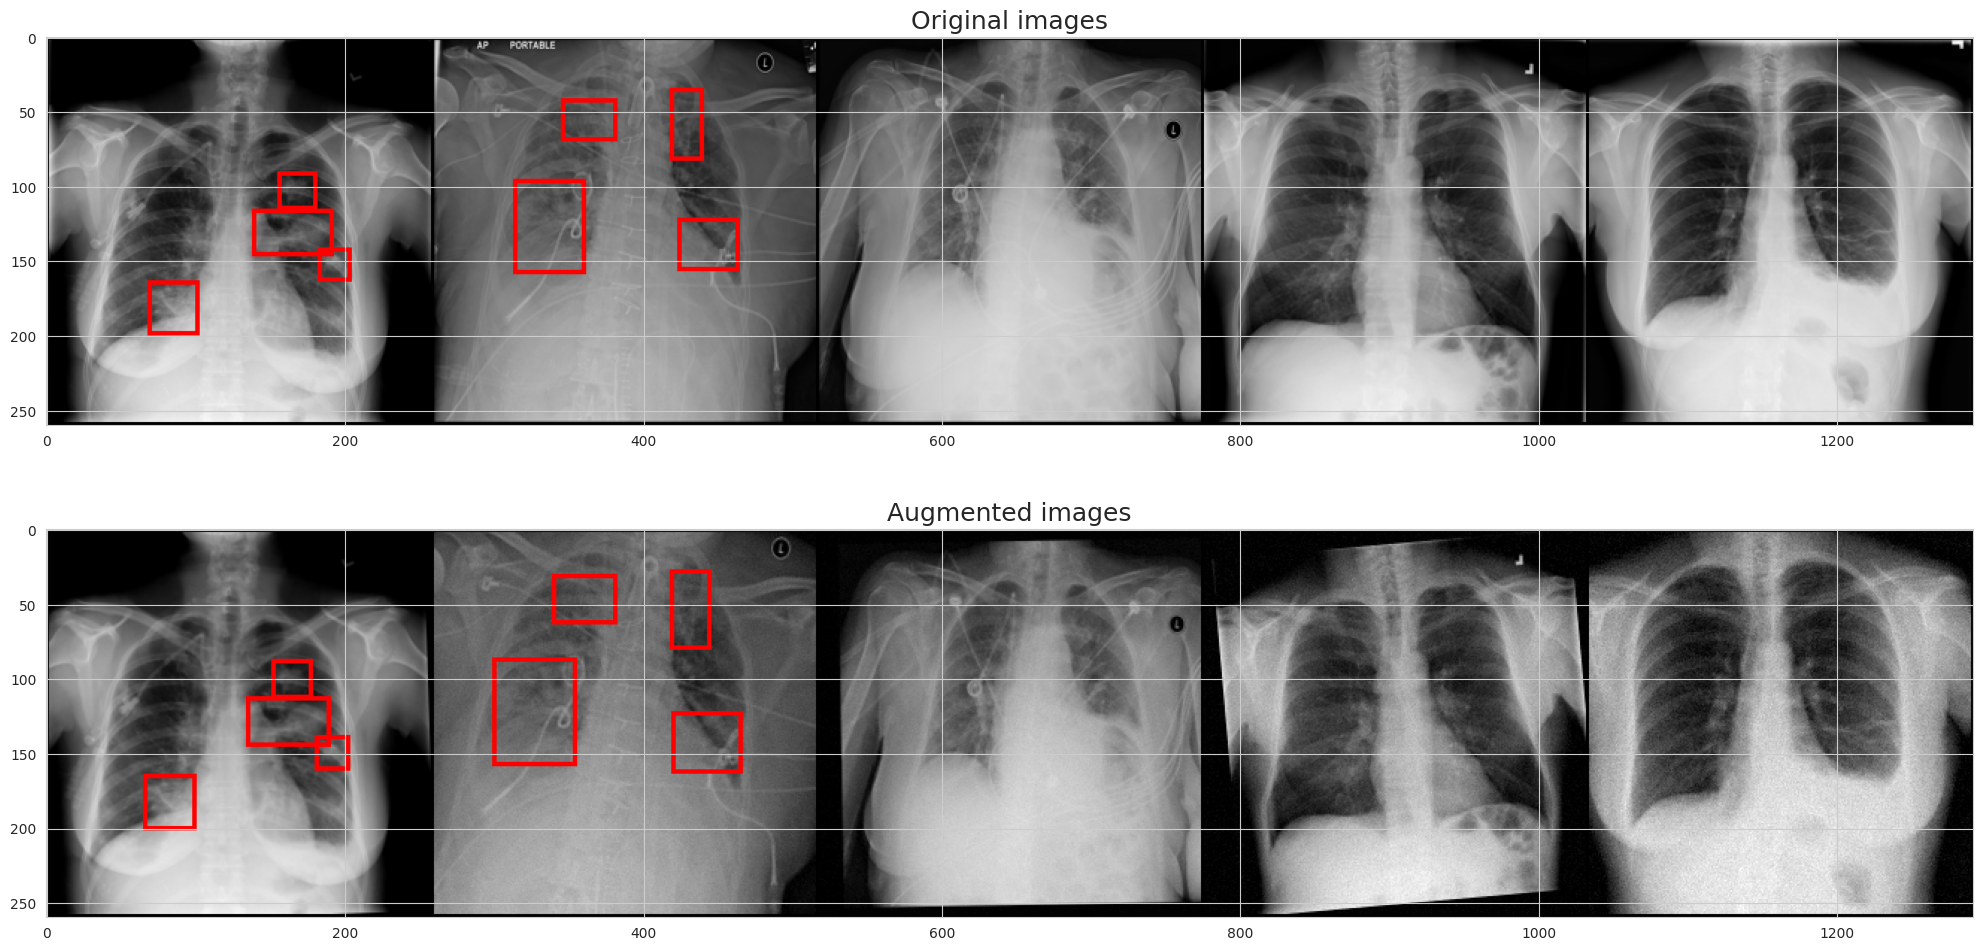

In [ ]:
def process_batch(idx, sample):
    img, boxes = sample

    augmentation = Augmentation()
    augmentation.worker_init_fn(idx)
    img, boxes = augmentation(img.numpy(), boxes.numpy())
    img = torch.tensor(img, dtype=torch.uint8)
    boxes = torch.tensor(boxes, dtype=torch.float32)
    return img, boxes


augmented_batch = sample_batch[:5] + [process_batch(i, sample) for i, sample in enumerate(sample_batch[:5])]
plot_samples(augmented_batch, titles=["Original images", "Augmented images"], fig_size=(20, 10), n_rows=2)
del sample_batch, augmented_batch


In [ ]:
pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
from torchvision.ops import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class LitRCNN(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        self.model = model
    def forward(self, x):
        self.model.eval()
        outputs =  self.model(x)
        preds = []
        for output in outputs:
            boxes = output["boxes"]
            scores = output["scores"]
            idx = nms(boxes,scores, 0.05)
            preds.append({"boxes": boxes[idx].cpu().detach().numpy(), "scores": scores[idx].cpu().detach().numpy()})
        return preds
    def training_step(self, batch, batch_idx):
        images, targets = batch
        losses = self.model(images, targets)
        loss = sum(loss for loss in losses.values())
        self.log_losses(loss, losses)
        return loss
    def validation_step(self, batch, batch_idx):
        self.model.train()
        images, targets = batch
        losses = self.model(images, targets)
        loss = sum(loss for loss in losses.values())
        self.log_losses(loss, losses, mode="val")
    def predict_step(self, batch, batch_idx):
        return self.forward(batch)
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(),  lr=0.005, momentum=0.9, weight_decay=0.0005)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1}}

    def log_losses(self, loss, losses, mode="train"):
        self.log_dict({f"{mode}_loss": loss,
                       f"{mode}_loss_box_reg": losses['loss_box_reg'],
                       f"{mode}_loss_objectness": losses['loss_objectness'],
                       f"{mode}_loss_rpn_box_reg": losses['loss_rpn_box_reg']}, on_step=False, on_epoch=True, batch_size=batch_size)

model = LitRCNN(num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 77.8MB/s]


We define some callbacks for logging and model checkpoints.

In [ ]:
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint


class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self, metrics):
        super().__init__()
        self.metrics = metrics
        self.training = {}
        self.validations = {}

    def on_train_epoch_end(self, trainer, pl_module):
        self.training[trainer.current_epoch] = {metric: trainer.callback_metrics["train_" + metric] for metric in self.metrics}

    def on_validation_end(self, trainer, pl_module):
        self.validations[trainer.current_epoch] = {metric: trainer.callback_metrics["val_" + metric] for metric in self.metrics}


checkpoint_callback = ModelCheckpoint(dirpath='checkpoints',
                                      filename='{epoch}-{val_loss:.4f}',
                                      every_n_epochs=1,
                                      monitor='val_loss',
                                      save_top_k=1,
                                      mode='min')

callbacks = [MetricsCallback(["loss"] + rcnn_losses), checkpoint_callback]

## Training

In [ ]:
device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(accelerator=device, max_epochs=1, callbacks=callbacks)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


## Evaluation
Now we can check some predictions on validation set.

In [ ]:
sample_batch_idx = np.random.choice(len(valid_imgs), size=5)
sample_batch = read_images(np.array(valid_ds.img_names)[sample_batch_idx], train_label_df, (train_img_size, train_img_size))

preds = model([valid_ds[i][0] for i in sample_batch_idx])
for i, pred in enumerate(preds):
    sample_batch.append((sample_batch[i][0],
                         torch.tensor(pred["boxes"], dtype=torch.int32),
                         pred["scores"]))

plot_samples(sample_batch, titles=["Validation", "Predictions"], fig_size=(20, 10), n_rows=2)

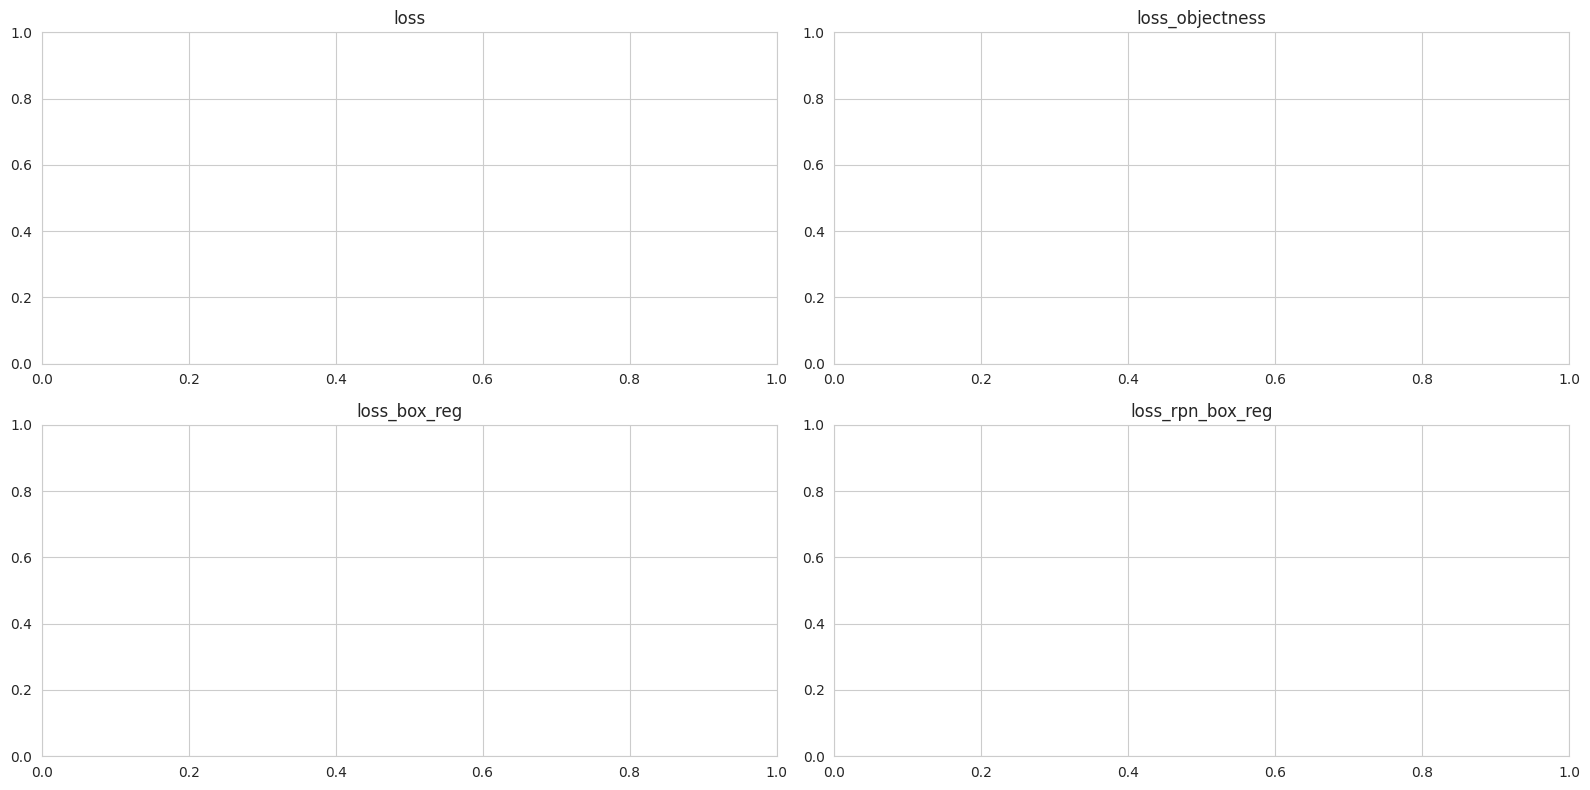

In [ ]:

sns.set_style("whitegrid")
training = pd.DataFrame.from_dict(callbacks[0].training, orient="index").applymap(lambda x: x.cpu().numpy())
validations = pd.DataFrame.from_dict(callbacks[0].validations, orient="index").applymap(lambda x: x.cpu().numpy())

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

for ax, metric in zip(axs.flat, callbacks[0].metrics):
    ax.set_title(metric)

    # Check if the metric key exists in the DataFrames
    if metric in training.index and metric in validations.index:
        # Extract the numeric values for the specific metric
        training_metric_values = training.loc[metric].values
        validations_metric_values = validations.loc[metric].values

        # Use the numeric values for the lineplot
        g = sns.lineplot(data=training_metric_values, ax=ax)
        g = sns.lineplot(data=validations_metric_values, ax=ax)
        g.set(xlabel="Epoch", ylabel=None)
        g.set_xticks(range(1, len(training_metric_values) + 1))  # Assuming epoch numbers start from 1
        ax.legend(labels=["Training", "Validation"])
    else:
        print(f"Warning: Metric '{metric}' not found in the DataFrames.")

fig.tight_layout()
plt.show()

In [ ]:
history = trainer.validate(model, dataloaders=valid_loader, verbose=False)
pd.DataFrame(history, index=["Validation"]).T

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

,Validation
val_loss,0.073671
val_loss_box_reg,0.034431
val_loss_objectness,0.004091
val_loss_rpn_box_reg,0.001276


## Submission

In [ ]:
preds = trainer.predict(model, test_loader)

outputs = []
for batch_pred in preds:
    for sample_pred in batch_pred:
        scores, boxes = sample_pred["scores"], sample_pred["boxes"]
        if len(scores) == 0:
            outputs.append(np.nan)
        else:
            label = ""
            boxes = boxes / scale_factor
            for score, box in zip(scores, boxes):
                label += f"{score:.2f} {box[0]:.1f} {box[1]:.1f} {(box[2]-box[0]):.1f} {(box[3]-box[1]):.1f} "
            outputs.append(label.strip())

submission = pd.read_csv(os.path.join(ROOT_DIR, SUBMISSION_FILE))
submission.PredictionString = outputs
submission.to_csv("submission.csv", header=True, index=False)
submission


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,NaN
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.25 314.2 203.2 130.3 179.1 0.11 660.3 479.5 ...
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.08 179.2 495.9 274.8 258.8 0.06 758.6 570.1 ...
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.11 230.5 407.1 223.1 313.8
4,00100a24-854d-423d-a092-edcf6179e061,0.57 251.1 599.2 148.0 193.5 0.56 515.2 345.1 ...
...,...,...
2995,c1e88810-9e4e-4f39-9306-8d314bfc1ff1,0.42 338.6 146.0 191.3 382.8 0.29 621.2 586.1 ...
2996,c1ec035b-377b-416c-a281-f868b7c9b6c3,0.29 253.3 580.6 203.3 191.0
2997,c1ef5b66-0fd7-49d1-ae6b-5af84929414b,0.14 243.3 394.4 195.9 363.1 0.07 631.3 533.1 ...
2998,c1ef6724-f95f-40f1-b25b-de806d9bc39d,0.72 215.6 327.6 246.2 395.6 0.28 617.0 342.1 ...
